# CGAN Test on MOMA Data<a name="top"></a>

This script uses a slightly modified Keras Conditional GAN to generate artifical mass spectra learned from the MOMA ML Dataset.

## Setup

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from tensorflow.keras.models import load_model, model_from_json
from sklearn import preprocessing

C:\Users\thegerg\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\thegerg\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\thegerg\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\thegerg\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarnin

In [3]:
# GPU Check
import tensorflow as tf 
tf.test.is_gpu_available()

True

## Prepare the Data

In [4]:
# Load dataset into pandas dataframe
full_df = pd.read_csv('full_ml_data.csv')
full_df.name = "Full Dataset"

In [5]:
# Normalize the spectral columns to be between 0 and 1, scaled by the max value in that row
# norm_spec_df = full_df.iloc[:,1:2001].apply(lambda x: x/x.max(), axis=1)
norm_spec_df = full_df.iloc[:,1:1297].apply(lambda x: x/x.max(), axis=1)

In [6]:
# Pad with zero columns if needed 
# for i in range(1,191):
#     col_name = str(1105 + i)
#     col_index = 1105 + i
#     norm_spec_df.insert(col_index,col_name,0,True)

In [7]:
# Encode labels
label_encoder = preprocessing.LabelEncoder()
y_train_cat = label_encoder.fit_transform(full_df['sample_label'])

# Map labels to encoding
target_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_,))

In [8]:
# Select full dataset for use in model
target_df = norm_spec_df.copy()

# Reshape mass specs into a square
target_train = np.reshape(target_df.values,(target_df.shape[0],36,36,1))

print(f"Number of examples: {len(target_train)}")
print(f"Shape of the images in the dataset: {target_train.shape[1:]}")

Number of examples: 26685
Shape of the images in the dataset: (36, 36, 1)


## Train the Model

In [9]:
import moma_cgan

In [10]:
# Setup input variables
#
# Number of latent dimensions, 100 is fine/standard
latent_dimensions = 100

# Spectrum training data, full dataset 
x_training_df = target_df

# Encoded Sample Labels
y_training = y_train_cat

# Number of classes in the training data
num_classes = len(np.unique(y_training))

In [ ]:
cgan = moma_cgan.CGAN(latent_dimensions, x_training_df, num_classes, y_training)
cgan.train(epochs=4000, batch_size=32, save_interval=50)

## Generate Spectra

In [12]:
# Epoch choice somewhat arbitrary
# load json and create model
json_file = open('CGAN/models/all/generator_model_3800.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('CGAN/models/all/generator_model_3800.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
# Review mapping
target_mapping

{0: 'AMP in Mont + Mg Perc.',
 1: 'Angiotensine+CHCA',
 2: 'Anhydrite',
 3: 'Atacama',
 4: 'Au-Coated CsI',
 5: 'BetaCarotene+FS121',
 6: 'CaSiO3',
 7: 'Calcite',
 8: 'Chlorophyll A',
 9: 'CsI',
 10: 'CsI in Gypsum',
 11: 'CsI in Hematite',
 12: 'CsI in Mont',
 13: 'DGDG',
 14: 'FeSO4.7H2O',
 15: 'Forsterite',
 16: 'Fspat1 powder',
 17: 'G24 powder',
 18: 'Glu in Mont',
 19: 'Glu in Mont + Mg Perc.',
 20: 'Gly+Ala+Ser mixture + CHCA',
 21: 'Gypsum',
 22: 'Hematite',
 23: 'Hopane',
 24: 'Kerogen (Type IV)',
 25: 'MGDG',
 26: 'Magadi',
 27: 'Magnetite',
 28: 'Mg Perc. in Mont',
 29: 'Mg2SiO4',
 30: 'Mgadi kerogen',
 31: 'Mix in Mont',
 32: 'Mix in Mont + Mg Perc.',
 33: 'MnSO4',
 34: 'Nontronite',
 35: 'Ocean World Analog',
 36: 'Phe in Mont',
 37: 'Phe in Mont + Mg Perc.',
 38: 'Phospholipids',
 39: 'Phosphorus',
 40: 'Phthalic Acid in Mont',
 41: 'Phthalic Acid in Mont + Mg Perc.',
 42: 'Rhodamine 6G',
 43: 'Saponite',
 44: 'Thin section (C coating)',
 45: 'Thin section (F093(WO5))',
 

In [14]:
# Select a sample label to generate
sample_label = 56

In [19]:
# generate inputs
latent_points, labels = moma_cgan.generate_latent_points(100, 9, sample_label)

# generate images
gen_X = loaded_model.predict([latent_points, labels])

# rescale from [0,1]
gen_X = .5 * gen_X + .5

# Reshape back to spectrum and convert to dataframe
gen_df = pd.DataFrame(gen_X.reshape(len(gen_X),1296))

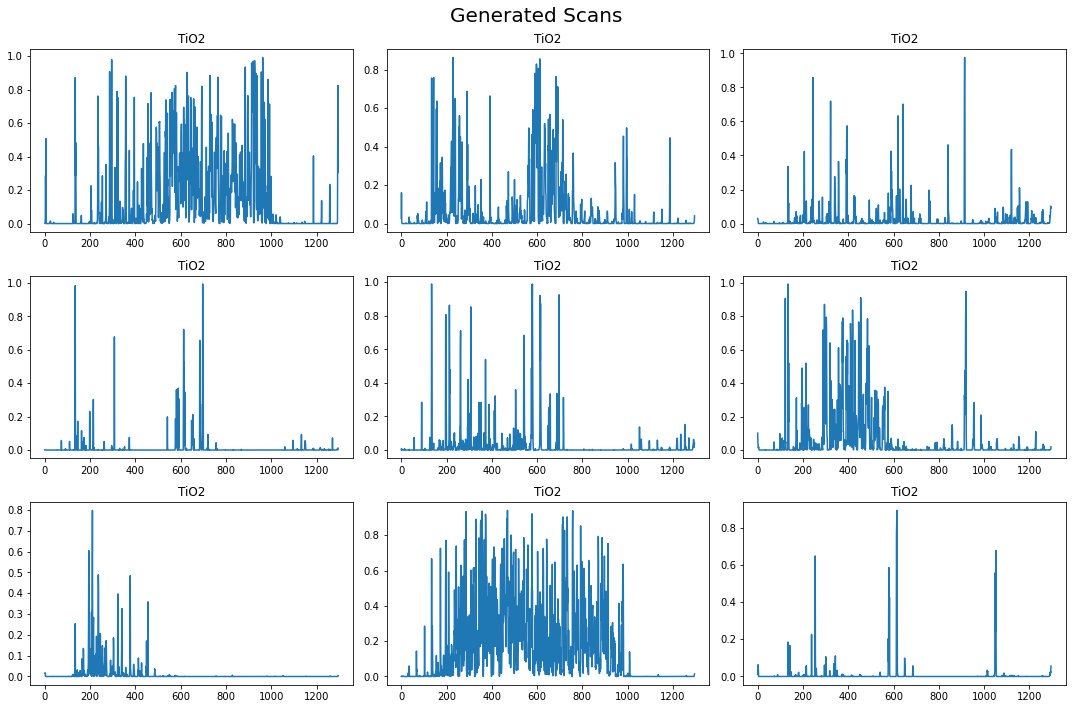

In [20]:
# Display mass specs
plt.figure(1, figsize=(15, 10))
plt.suptitle('Generated Scans', fontsize=20)

k = 0
for i in range(0,len(gen_df)):
    plt.subplot(3, 3, k+1)
    plt.plot(gen_df.loc[i])
    plt.title(target_mapping[sample_label])
    k += 1
    
plt.tight_layout()
plt.show()

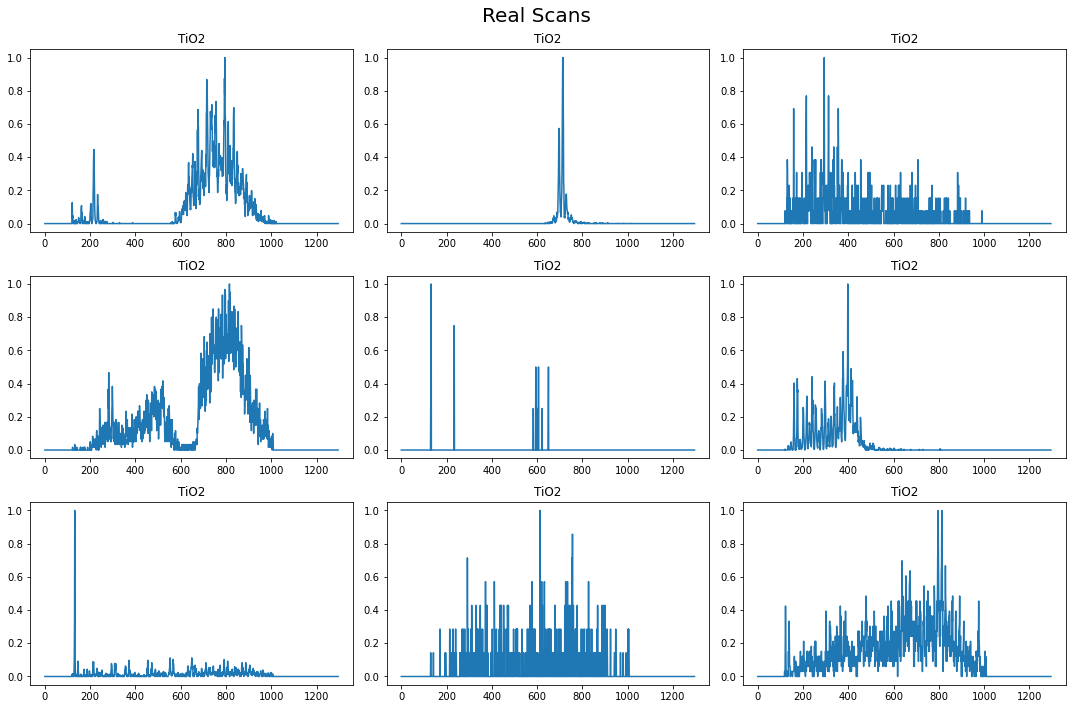

In [23]:
# Show real scans
target_name = 'TiO2'

# Get all rows for the target sample label
target_rows = full_df.loc[full_df['sample_label'] == target_name].index

# Create dataframe of only target sample
target_df = norm_spec_df.loc[target_rows]

# Display mass specs
plt.figure(1, figsize=(15, 10))
plt.suptitle('Real Scans', fontsize=20)

k = 0
for i in range(0,9):
    fig = plt.subplot(3, 3, k+1)
    plt.plot(target_df.iloc[random.randrange(len(target_df))])
    plt.title(target_name)
    fig.set_xticks([0,200,400,600,800,1000,1200])
    k += 1
    
plt.tight_layout()
plt.show()